In [194]:
print("start")

start


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from datetime import datetime
import matplotlib.pyplot as plt

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import TimeSeriesSplit
from keras import optimizers

from keras.layers import LSTM, Dense, Input, Bidirectional
from keras.models import Sequential, Model
import keras.backend as K 
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [3]:
pd.set_option('display.max_row', 300)
pd.set_option('display.max_columns', 100)

In [4]:
data_kor = pd.read_csv("data_kor.csv", index_col = 0)
data_kor

,date,new_cases,total_deaths,new_deaths,new_deaths_smoothed,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people,H8_Flag,M1_Wildcard,기온(°C),강수량(mm),습도(%),일조(hr),적설(cm),지면온도(°C),is_holiday
0,2020-01-21,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,11.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,0.844868,0.000614,51.693860,0.364693,0.00136,1.107193,0
1,2020-01-22,0.0,0.0,0.0,0.000,0.000,0.000,0.000,5.0,16.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,3.157851,0.160307,67.774123,0.020833,0.00000,2.422193,0
2,2020-01-23,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,5.530898,0.155502,79.423856,0.157835,0.00000,5.061664,0
3,2020-01-24,1.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,25.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,4.654605,0.027939,74.022807,0.271535,0.00000,4.275658,1
4,2020-01-25,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,5.179254,0.015263,78.046491,0.053333,0.00000,4.545000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,2021-06-18,482.0,1997.0,1.0,2.143,38.951,0.020,0.042,31694.0,10168211.0,198.330,0.618,27271.0,0.532,0.017,57.9,0.0,0.0,0.0,0.0,423495.0,0.00,0.00,0.00,8260.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,0.0,9.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,3.0,2.0,0.0,0.0,3.0,1.0,3.0,1.0,2.0,1.0,9.0,20.770746,0.129430,89.288596,0.028246,0.00000,22.718070,0
515,2021-06-19,429.0,2002.0,5.0,2.429,39.049,0.098,0.047,26222.0,10194433.0,198.841,0.511,25157.0,0.491,0.019,53.8,0.0,0.0,0.0,0.0,398825.0,0.00,0.00,0.00,7779.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,0.0,9.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,3.0,2.0,0.0,0.0,3.0,1.0,3.0,1.0,2.0,1.0,9.0,22.110000,0.000000,75.495175,0.446360,0.00000,26.506886,0
516,2021-06-20,357.0,2004.0,2.0,2.286,39.088,0.039,0.045,10139.0,10204572.0,199.039,0.198,25169.0,0.491,0.018,54.5,17946801.0,15014819.0,4047846.0,0.0,444627.0,35.01,29.29,7.90,8672.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,0.0,9.0,1.0,1.0,1.0,1.0,2.0,1.

# MODELING

In [5]:
df_k = data_kor.iloc[:,1:]
df_k

,new_cases,total_deaths,new_deaths,new_deaths_smoothed,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people,H8_Flag,M1_Wildcard,기온(°C),강수량(mm),습도(%),일조(hr),적설(cm),지면온도(°C),is_holiday
0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,11.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,0.844868,0.000614,51.693860,0.364693,0.00136,1.107193,0
1,0.0,0.0,0.0,0.000,0.000,0.000,0.000,5.0,16.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,3.157851,0.160307,67.774123,0.020833,0.00000,2.422193,0
2,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,5.530898,0.155502,79.423856,0.157835,0.00000,5.061664,0
3,1.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,25.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,4.654605,0.027939,74.022807,0.271535,0.00000,4.275658,1
4,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,5.179254,0.015263,78.046491,0.053333,0.00000,4.545000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,482.0,1997.0,1.0,2.143,38.951,0.020,0.042,31694.0,10168211.0,198.330,0.618,27271.0,0.532,0.017,57.9,0.0,0.0,0.0,0.0,423495.0,0.00,0.00,0.00,8260.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,0.0,9.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,3.0,2.0,0.0,0.0,3.0,1.0,3.0,1.0,2.0,1.0,9.0,20.770746,0.129430,89.288596,0.028246,0.00000,22.718070,0
515,429.0,2002.0,5.0,2.429,39.049,0.098,0.047,26222.0,10194433.0,198.841,0.511,25157.0,0.491,0.019,53.8,0.0,0.0,0.0,0.0,398825.0,0.00,0.00,0.00,7779.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,0.0,9.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,3.0,2.0,0.0,0.0,3.0,1.0,3.0,1.0,2.0,1.0,9.0,22.110000,0.000000,75.495175,0.446360,0.00000,26.506886,0
516,357.0,2004.0,2.0,2.286,39.088,0.039,0.045,10139.0,10204572.0,199.039,0.198,25169.0,0.491,0.018,54.5,17946801.0,15014819.0,4047846.0,0.0,444627.0,35.01,29.29,7.90,8672.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,0.0,9.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,3.0,2.0,0.0,0.0,3.0,1.0,3.0,1.0,2.0,1.0,9.0,22.588509,0.000395,71.23157

In [6]:
train_s = df_k[:-10]
test_s = df_k[-10:]
train_l = df_k[:-30]
test_l = df_k[-30:]

In [7]:
tr_x_s = train_s.iloc[:,1:]
tr_y_s = train_s.iloc[:,:1]
te_x_s = test_s.iloc[:,1:]
te_y_s = test_s.iloc[:,:1]

tr_x_l = train_l.iloc[:,1:]
tr_y_l = train_l.iloc[:,:1]
te_x_l = test_l.iloc[:,1:]
te_y_l = test_l.iloc[:,:1]

In [8]:
tr_x_s = tr_x_s.values
tr_y_s = tr_y_s.values
te_x_s = te_x_s.values
te_y_s = te_y_s.values

tr_x_l = tr_x_l.values
tr_y_l = tr_y_l.values
te_x_l = te_x_l.values
te_y_l = te_y_l.values

In [9]:
print(tr_x_s.shape)
print(tr_x_s)
# print("")
# print(te_y.shape)
# print(te_y)

(509, 63)
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.35964912e-03
  1.10719298e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  2.42219298e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  5.06166373e+00 0.00000000e+00]
 ...
 [1.98100000e+03 2.00000000e+00 1.71400000e+00 ... 0.00000000e+00
  2.54262281e+01 0.00000000e+00]
 [1.98200000e+03 1.00000000e+00 1.57100000e+00 ... 0.00000000e+00
  2.38750439e+01 0.00000000e+00]
 [1.98500000e+03 3.00000000e+00 1.71400000e+00 ... 0.00000000e+00
  2.62373246e+01 0.00000000e+00]]


In [10]:
tr_x_s_ = tr_x_s.reshape(tr_x_s.shape[0],63,1)
te_x_s_ = te_x_s.reshape(te_x_s.shape[0],63,1)
tr_x_l_ = tr_x_l.reshape(tr_x_l.shape[0],63,1)
te_x_l_ = te_x_l.reshape(te_x_l.shape[0],63,1)

In [11]:
print(tr_x_s_.shape)
print(te_x_s_.shape)

(509, 63, 1)
(10, 63, 1)


In [12]:
print(tr_x_l_.shape)
print(te_x_l_.shape)

(489, 63, 1)
(30, 63, 1)


# LSTM
## Short Term

In [22]:
K.clear_session()
model = Sequential()

model.add(LSTM(32, activation ='relu', input_shape=(63,1), return_sequences = True))
model.add(LSTM(32, return_sequences = False))
model.add(Dense(32))
model.add(Dense(16))
model.add(Dense(8))
model.add(Dense(1))
adam = optimizers.Adam(lr = 0.05)
model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['mse'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 63, 32)            4352      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 14,401
Trainable params: 14,401
Non-trainable params: 0
__________________________________________________

In [23]:
early_stop = EarlyStopping(monitor="loss", patience = 3, verbose=1)
model.fit(tr_x_s_, tr_y_s, epochs = 100, batch_size = 3, verbose=1, callbacks =[early_stop])

Epoch 1/100
509/509 [==============================] - 20s 39ms/step - loss: 153874.7283 - mse: 153874.7188
Epoch 2/100
509/509 [==============================] - 19s 38ms/step - loss: 105582.9342 - mse: 105582.9453
Epoch 3/100
509/509 [==============================] - 20s 39ms/step - loss: 85176.2925 - mse: 85176.2812
Epoch 4/100
509/509 [==============================] - 19s 37ms/step - loss: 69247.2850 - mse: 69247.2500
Epoch 5/100
509/509 [==============================] - 19s 38ms/step - loss: 73383.1800 - mse: 73383.1719
Epoch 6/100
509/509 [==============================] - 20s 39ms/step - loss: 79918.2198 - mse: 79918.2422
Epoch 7/100
509/509 [==============================] - 19s 37ms/step - loss: 79311.2219 - mse: 79311.2188
Epoch 00007: early stopping


In [24]:
y_pred_s = model.predict(te_x_s_)
real_s = np.concatenate((tr_y_s, te_y_s))
forecast_s = np.concatenate((tr_y_s, y_pred_s))

In [25]:
# RMSE를 살펴 봄
RMSE_LSTM_s  = np.mean(np.sqrt((y_pred_s[:9] - te_y_s[:9]) ** 2)) 
print(RMSE_LSTM_s)

134.51063028971353


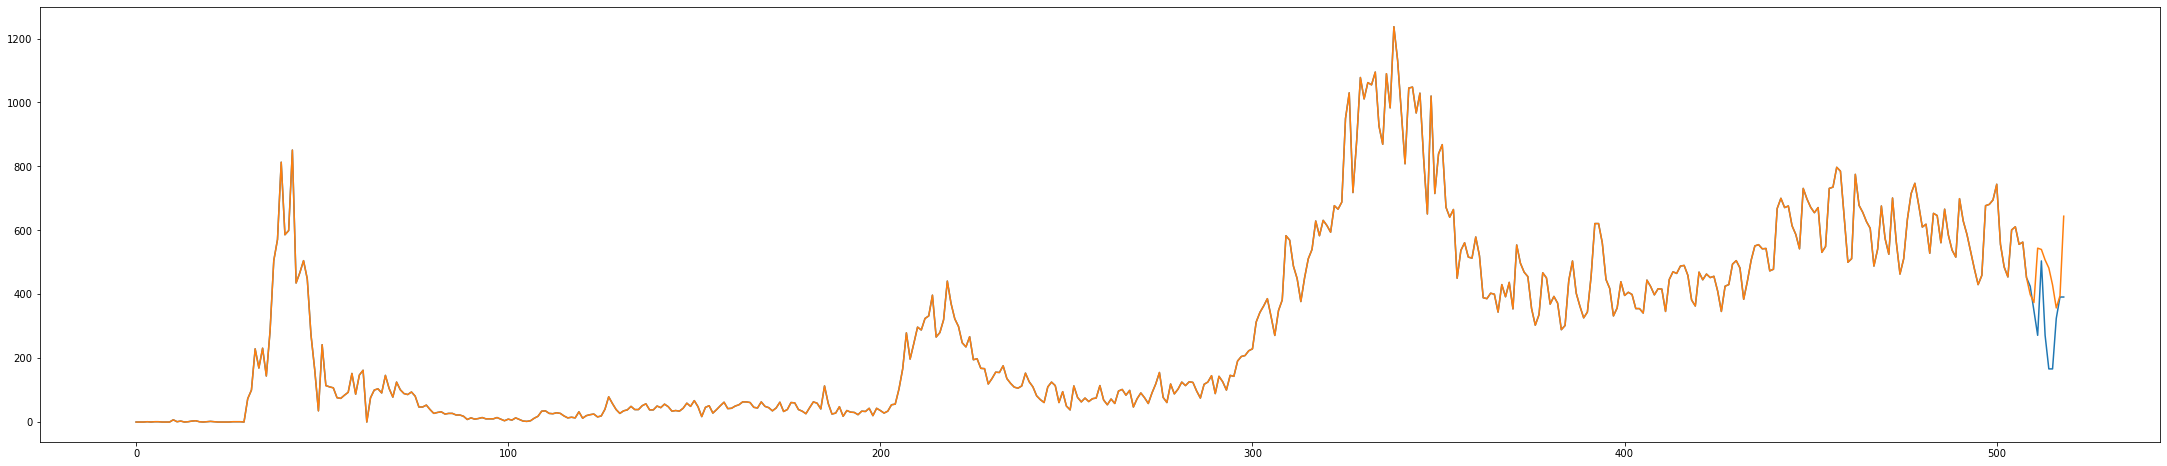

In [26]:
plt.rcParams["figure.figsize"] = (38,8)
plt.plot(forecast_s, label = "forecast")
plt.plot(real_s, label = "real")
plt.legend
plt.show()

## Long term

In [27]:
early_stop = EarlyStopping(monitor="loss", patience = 3, verbose=1)
model.fit(tr_x_l_, tr_y_l, epochs = 100, batch_size = 3, verbose=1, callbacks =[early_stop])

Epoch 1/100
489/489 [==============================] - 16s 32ms/step - loss: 73719.0083 - mse: 73719.0000
Epoch 2/100
489/489 [==============================] - 14s 29ms/step - loss: 69787.5602 - mse: 69787.5391
Epoch 3/100
489/489 [==============================] - 14s 29ms/step - loss: 67726.7852 - mse: 67726.7969
Epoch 4/100
489/489 [==============================] - 15s 30ms/step - loss: 53634.3880 - mse: 53634.3984
Epoch 5/100
489/489 [==============================] - 15s 30ms/step - loss: 40457.5797 - mse: 40457.5781
Epoch 6/100
489/489 [==============================] - 15s 31ms/step - loss: 51368.5244 - mse: 51368.5234
Epoch 7/100
489/489 [==============================] - 15s 31ms/step - loss: 60614.0466 - mse: 60614.0469
Epoch 8/100
489/489 [==============================] - 15s 30ms/step - loss: 37416.7964 - mse: 37416.7969
Epoch 9/100
489/489 [==============================] - 14s 29ms/step - loss: 29344.8163 - mse: 29344.8164
Epoch 10/100
489/489 [========================

In [28]:
y_pred_l = model.predict(te_x_l_)
real_l = np.concatenate((tr_y_l, te_y_l))
forecast_l = np.concatenate((tr_y_l, y_pred_l))

In [29]:
# RMSE를 살펴 봄
RMSE_LSTM_l  = np.mean(np.sqrt((y_pred_l[:9] - te_y_l[:9]) ** 2)) 
print(RMSE_LSTM_l)

100.10120307074652


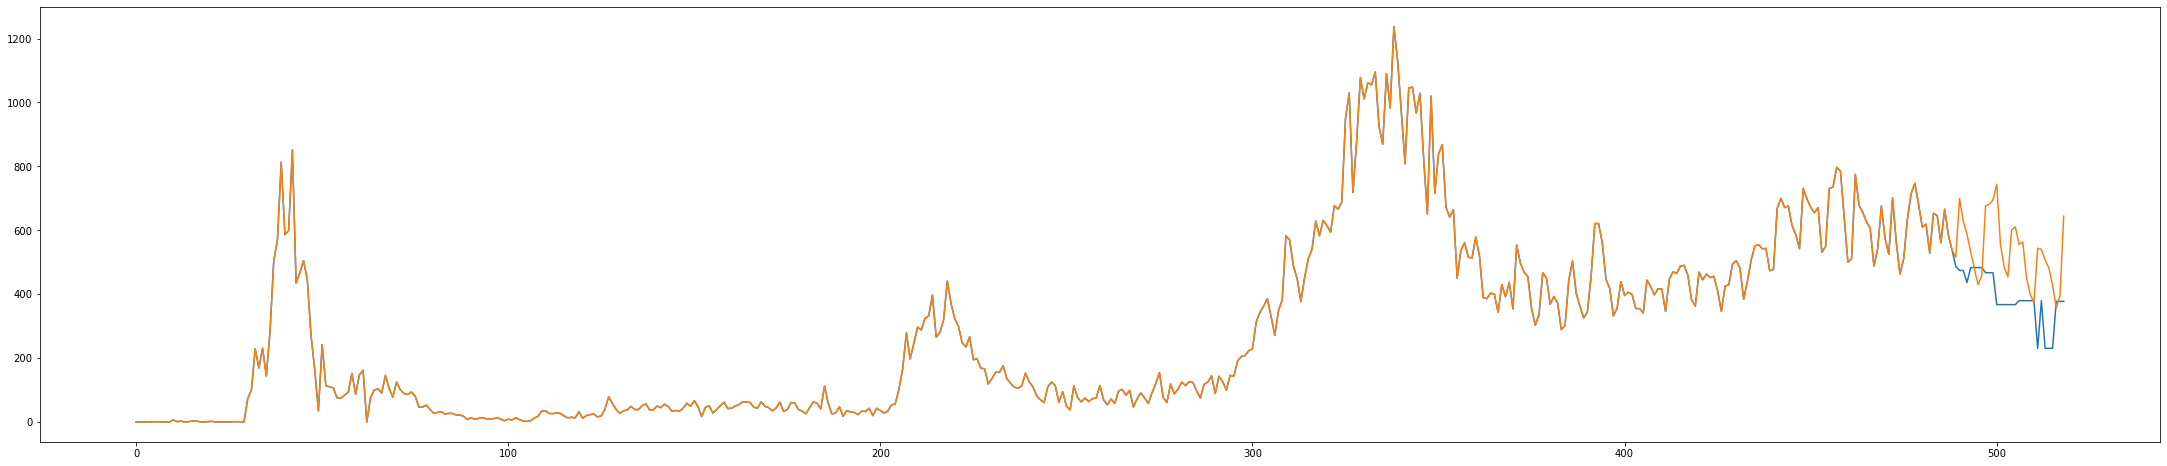

In [30]:
plt.rcParams["figure.figsize"] = (38,8)
plt.plot(forecast_l, label = "forecast")
plt.plot(real_l, label = "real")
plt.legend
plt.show()

# Bidirectional LSTM

## Short Term

In [36]:
model2 = Sequential()
model2.add(Bidirectional(LSTM(64, activation='sigmoid'), input_shape=(63,1)))
model2.add(Dense(64))
model2.add(Dense(32))
model2.add(Dense(16))
model2.add(Dense(8))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['mse'])
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 128)               33792     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 44,801
Trainable params: 44,801
Non-trainable params: 0
__________________________________________________

In [37]:
early_stop = EarlyStopping(monitor="loss", patience = 3, verbose=1)
model2.fit(tr_x_s_, tr_y_s, epochs = 100, batch_size = 3, verbose=1, callbacks =[early_stop])

Epoch 1/100
509/509 [==============================] - 20s 39ms/step - loss: 94251.1821 - mse: 94251.2344
Epoch 2/100
509/509 [==============================] - 19s 36ms/step - loss: 40217.4759 - mse: 40217.4805
Epoch 3/100
509/509 [==============================] - 19s 37ms/step - loss: 25342.9423 - mse: 25342.9355
Epoch 4/100
509/509 [==============================] - 18s 36ms/step - loss: 24802.9372 - mse: 24802.9395
Epoch 5/100
509/509 [==============================] - 19s 37ms/step - loss: 22506.0637 - mse: 22506.0547
Epoch 6/100
509/509 [==============================] - 18s 35ms/step - loss: 22639.5694 - mse: 22639.5723
Epoch 7/100
509/509 [==============================] - 20s 39ms/step - loss: 21206.9191 - mse: 21206.9180
Epoch 8/100
509/509 [==============================] - 18s 35ms/step - loss: 21648.8138 - mse: 21648.8066
Epoch 9/100
509/509 [==============================] - 19s 37ms/step - loss: 21884.3839 - mse: 21884.3887
Epoch 10/100
509/509 [========================

In [38]:
y_pred_s2 = model2.predict(te_x_s_)
real_s2 = np.concatenate((tr_y_s, te_y_s))
forecast_s2 = np.concatenate((tr_y_s, y_pred_s2))

In [39]:
# RMSE를 살펴 봄
RMSE_LSTM_s2  = np.mean(np.sqrt((y_pred_s2[:9] - te_y_s[:9]) ** 2)) 
print(RMSE_LSTM_s2)

167.44401041666666


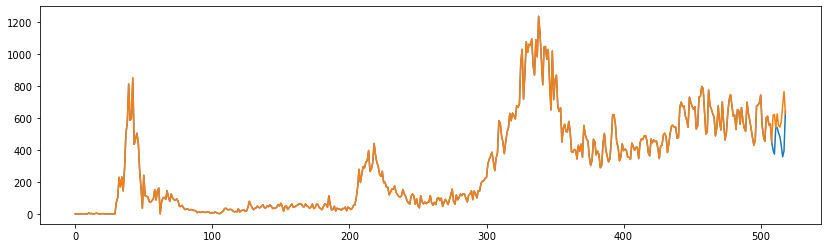

In [40]:
plt.rcParams["figure.figsize"] = (14,4)
plt.plot(real_s2, label = "real")
plt.plot(forecast_s2, label = "forecast")
# plt.xlim([450,530])
plt.legend
plt.show()

## Long Term

In [ ]:
early_stop = EarlyStopping(monitor="loss", patience = 3, verbose=1)
model.fit(tr_x_l_, tr_y_l, epochs = 100, batch_size = 3, verbose=1, callbacks =[early_stop])

In [ ]:
y_pred_l = model.predict(te_x_l_)
real_l = np.concatenate((tr_y_l, te_y_l))
forecast_l = np.concatenate((tr_y_l, y_pred_l))

In [ ]:
# RMSE를 살펴 봄
RMSE_LSTM_l  = np.mean(np.sqrt((y_pred_l[:9] - te_y_l[:9]) ** 2)) 
print(RMSE_LSTM_l)

In [ ]:
plt.rcParams["figure.figsize"] = (38,8)
plt.plot(forecast_l, label = "forecast")
plt.plot(real_l, label = "real")
plt.legend
plt.show()

# ARIMA

## Short Term

In [249]:
from pylab import rcParams
import statsmodels.api as sm
import warnings
import itertools
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

In [250]:
a_df_k = data_kor.iloc[:,:2]
a_df_k['date'] =  pd.to_datetime(a_df_k['date'])
a_df_k=a_df_k.set_index('date')
a_df_k

,new_cases
date,
2020-01-21,0.0
2020-01-22,0.0
2020-01-23,0.0
2020-01-24,1.0
2020-01-25,0.0
...,...
2021-06-18,482.0
2021-06-19,429.0
2021-06-20,357.0


In [251]:
case_by_day = a_df_k.new_cases.resample('d').sum()
split = "2021-06-14"
a_kr_train = case_by_day[:split]
a_kr_test = case_by_day[split:]
a_kr_final = a_kr_test.copy()

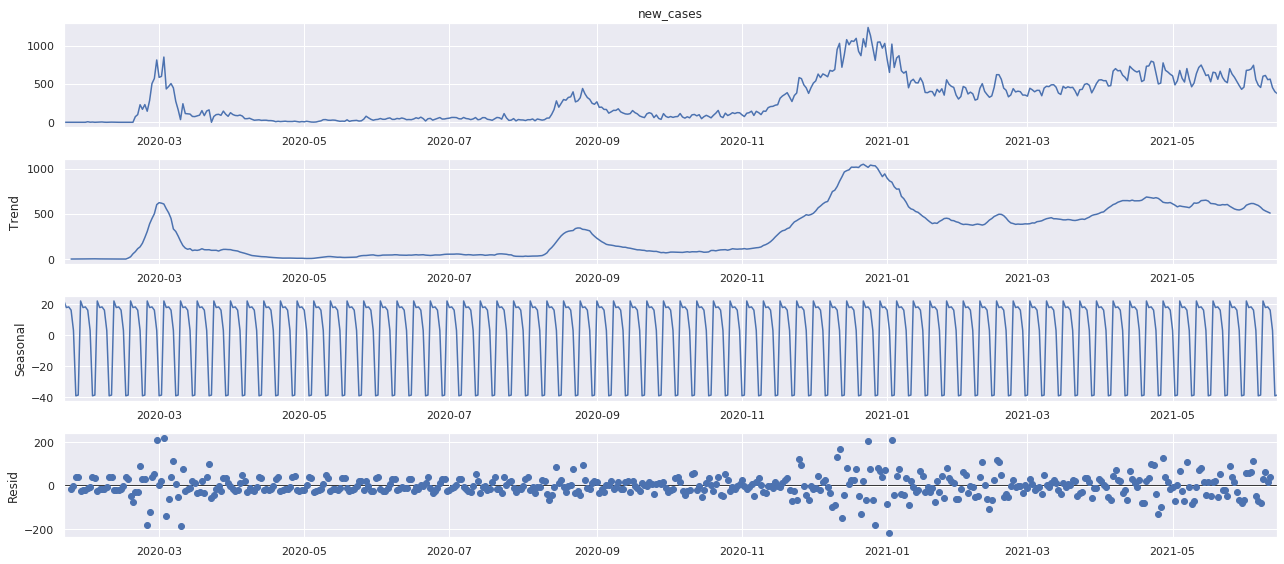

In [252]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(a_kr_train, model='additive')
fig = decomposition.plot()
plt.show()

In [253]:
#p,d,q의 조합을 만들어 하나하나 ARIMA 모델을 돌려봄
p = d = q = range(0, 2)

import itertools
pdqa = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdqa:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(a_kr_train, order = param, seasonal_order = param_seasonal, enforce_stationarity = False, enforce_invertibility = False)                                
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7571.240230860018
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6991.1358090542
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:6575.194381349351
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:6427.394312634304


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:6574.6330586664035
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:6564.2871358227785
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:6440.355900794486
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:6404.301172826672
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6984.756827412419
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6501.3025371280455
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:6220.736688134082
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:6062.1053432317285
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:6220.667155774097
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:6191.349560863049
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:6092.493724335076
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:6031.643629976129
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:5838.965935393438
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:5713.361715344747
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:6077.40169442233
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:5614.68015257342
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:5724.116828654307
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:5715.067999721739
ARIMA(0,

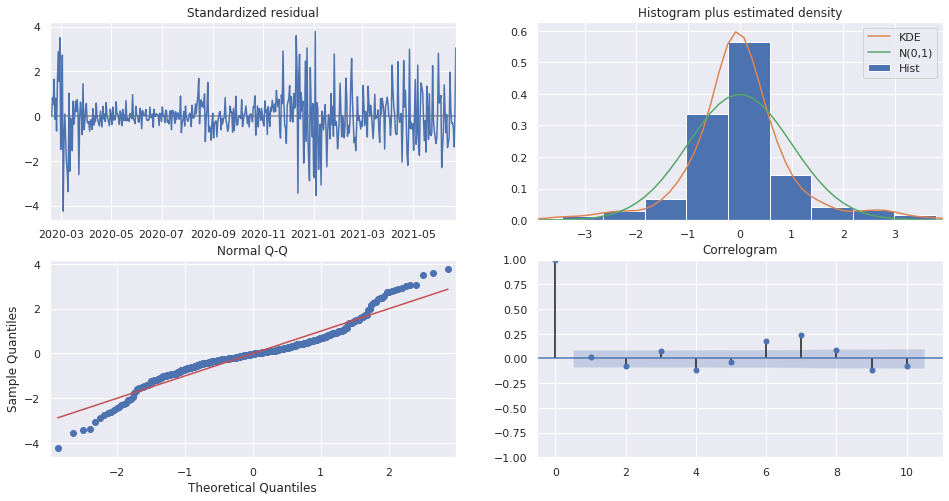

In [254]:
NEW_CASES  = sm.tsa.statespace.SARIMAX(case_by_day , order=(1, 1, 1), seasonal_order=(0, 1, 1, 12) , enforce_stationarity = False, enforce_invertibility = False)

SARIMA_results_day = NEW_CASES.fit()

SARIMA_results_day.plot_diagnostics(figsize=(16, 8))
plt.show()

In [255]:
SARIMA_predict_day = SARIMA_results_day.predict(start=len(case_by_day)-10, end=len(case_by_day))

# 결과 비교를 위해 기존에 마련해둔 test데이터에 결과를 붙임
a_kr_final['predicted'] = SARIMA_predict_day


In [256]:
# RMSE를 살펴 봄
RMSE_daily_ARIMA  = np.mean(np.sqrt((SARIMA_predict_day - a_kr_test) ** 2)) 
print(RMSE_daily_ARIMA)

72.59016294567499


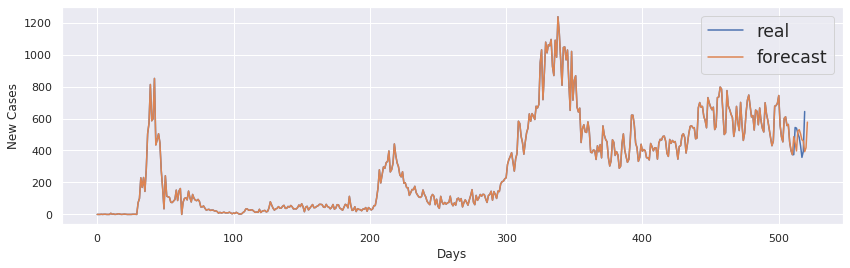

In [257]:
# test 데이터와 예측 결과치를 비교

real3 = np.concatenate((a_kr_train, a_kr_test))
forecast3 = np.concatenate((a_kr_train, SARIMA_predict_day))

plt.rcParams["figure.figsize"] = (14,4)
plt.plot(real3, label = "real")
plt.plot(forecast3, label = "forecast")
plt.xlabel("Days")
plt.ylabel("New Cases")
plt.legend(fontsize='x-large')
plt.show()

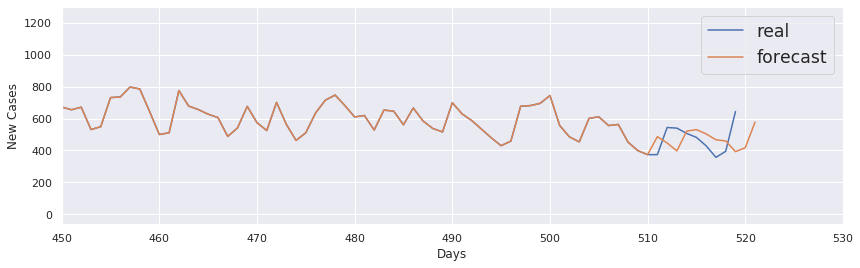

In [258]:
# test 데이터와 예측 결과치를 비교

real3 = np.concatenate((a_kr_train, a_kr_test))
forecast3 = np.concatenate((a_kr_train, SARIMA_predict_day))

plt.rcParams["figure.figsize"] = (14,4)
plt.plot(real3, label = "real")
plt.plot(forecast3, label = "forecast")
plt.xlim([450,530])
plt.xlabel("Days")
plt.ylabel("New Cases")
plt.legend(fontsize='x-large')
plt.show()

## Long Term

In [259]:
case_by_day = a_df_k.new_cases.resample('d').sum()
split = "2021-05-23"
a_kr_train = case_by_day[:split]
a_kr_test = case_by_day[split:]
a_kr_final = a_kr_test.copy()


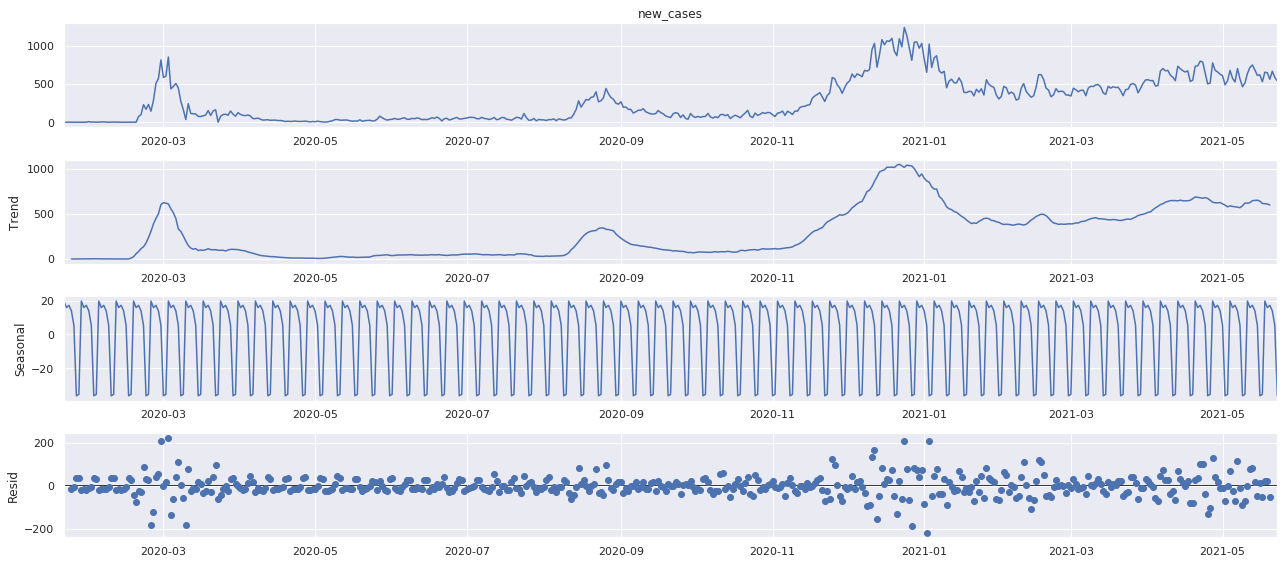

In [260]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(a_kr_train, model='additive')
fig = decomposition.plot()
plt.show()

In [261]:
#p,d,q의 조합을 만들어 하나하나 ARIMA 모델을 돌려봄
p = d = q = range(0, 2)

import itertools
pdqa = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdqa:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(a_kr_train, order = param, seasonal_order = param_seasonal, enforce_stationarity = False, enforce_invertibility = False)                                
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
        

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7223.562983535885
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6672.379582445646
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:6291.350805619582
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:6144.0848901319
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:6293.467473606772
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:6283.050765940157
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:6156.860867604233
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:6124.152300437407
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6664.95747388444
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6201.550996937376
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:5948.96763008247
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:5793.400438088998
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:5951.895320114669
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:5924.252489871537
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:5822.725858718114
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:5765.45726042074
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:5576.085356594728
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:5451.4316031869
ARIMA(0, 1, 0)x(0

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:5763.245779973266
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:5356.29177213831
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:5461.169834381009
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:5463.619518123937
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:5521.490703368797
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:5357.7196831777665
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:5544.257028306056
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:5419.558190115244
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:5746.574488531521
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:5319.330067512575
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:5430.376931400968
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:5420.326691481874
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:5514.936253539792
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:5319.892452244174
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:5555.683167793503
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:5430.312945193213
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:5782.436627271782
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:5332.239470816877
ARIMA(1, 1

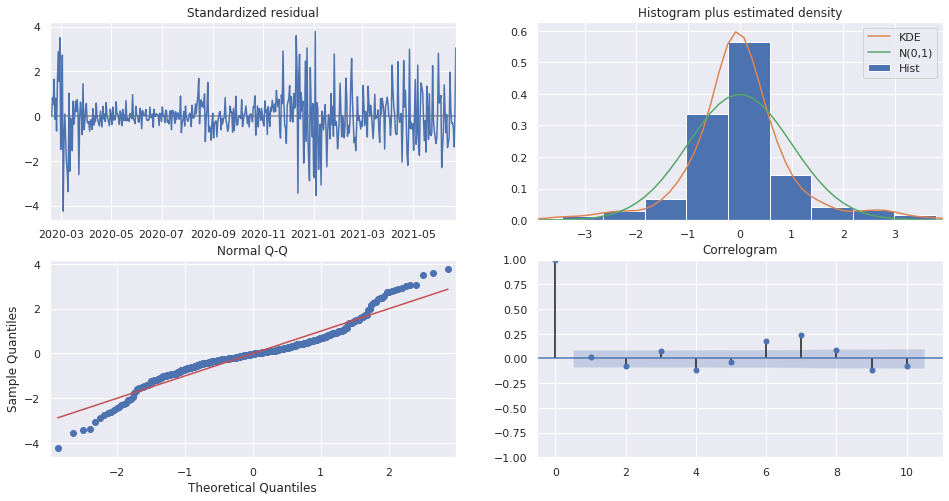

In [262]:
NEW_CASES  = sm.tsa.statespace.SARIMAX(case_by_day , order=(1, 1, 1), seasonal_order=(0, 1, 1, 12) , enforce_stationarity = False, enforce_invertibility = False)

SARIMA_results_day = NEW_CASES.fit()

SARIMA_results_day.plot_diagnostics(figsize=(16, 8))
plt.show()

In [263]:
SARIMA_predict_day = SARIMA_results_day.predict(start=len(case_by_day)-30, end=len(case_by_day))

# 결과 비교를 위해 기존에 마련해둔 test데이터에 결과를 붙임
a_kr_final['predicted'] = SARIMA_predict_day


In [264]:
# RMSE를 살펴 봄
RMSE_daily_ARIMA  = np.mean(np.sqrt((SARIMA_predict_day - a_kr_test) ** 2)) 
print(RMSE_daily_ARIMA)

75.36925640650655


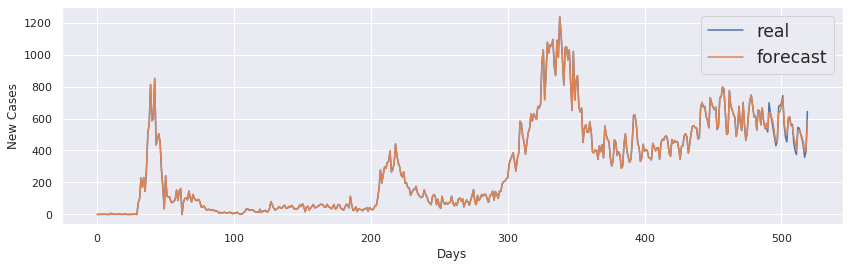

In [265]:
# test 데이터와 예측 결과치를 비교

real3 = np.concatenate((a_kr_train, a_kr_test))
forecast3 = np.concatenate((a_kr_train, SARIMA_predict_day))

plt.rcParams["figure.figsize"] = (14,4)
plt.plot(real3, label = "real")
plt.plot(forecast3, label = "forecast")
plt.xlabel("Days")
plt.ylabel("New Cases")
plt.legend(fontsize='x-large')
plt.show()

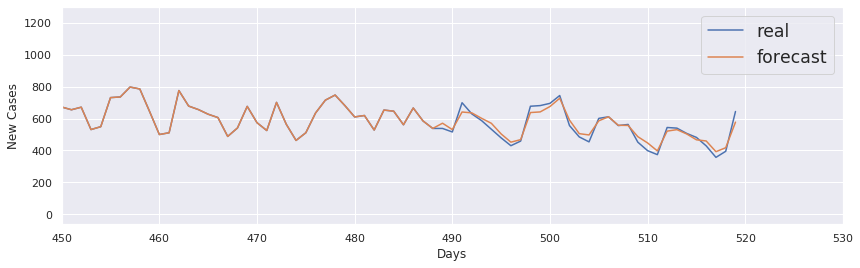

In [266]:
# test 데이터와 예측 결과치를 비교

real3 = np.concatenate((a_kr_train, a_kr_test))
forecast3 = np.concatenate((a_kr_train, SARIMA_predict_day))

plt.rcParams["figure.figsize"] = (14,4)
plt.plot(real3, label = "real")
plt.plot(forecast3, label = "forecast")
plt.xlim([450,530])
plt.xlabel("Days")
plt.ylabel("New Cases")
plt.legend(fontsize='x-large')
plt.show()

# Vector Auto Regression (VAR)

## Short Term

In [267]:
df_temp_kor = data_kor.iloc[:, 2:]
df_out_kor = []
for col in df_temp_kor.columns.tolist():
    if(type(df_temp_kor[col]) != "str"):
        tau, p_value = stats.kendalltau(data_kor['new_cases'], df_temp_kor[col])
        df_out_kor.append([np.abs(tau), p_value, col])

In [268]:
def Sort(sub_li):
    return(sorted(sub_li, key = lambda x: x[0])) 

In [269]:
sorted_out = Sort(df_out_kor)
sorted_out[-20:]

[[0.42020298821268925, 7.6378248881956e-35, 'new_vaccinations'],
 [0.4279399728634909, 1.20293227795676e-32, 'H7_Flag'],
 [0.44381297922859475, 2.4830791023844504e-36, 'H7_Vaccination policy'],
 [0.4620078268433285, 7.381113403853731e-50, 'new_deaths'],
 [0.4620078268433285, 7.381113403853731e-50, 'new_deaths_per_million'],
 [0.4922627854362075, 1.7766127648159855e-61, 'new_deaths_smoothed'],
 [0.4922627854362075,
  1.7766127648159855e-61,
  'new_deaths_smoothed_per_million'],
 [0.5045595357926425, 5.8218431507331794e-65, 'new_tests'],
 [0.5060498864810563, 3.2290338468323855e-65, 'new_tests_per_thousand'],
 [0.5151951054419672, 2.4298682656846477e-68, 'total_tests'],
 [0.5162252894576506, 1.4960694308763062e-68, 'total_tests_per_thousand'],
 [0.5598027959084709, 9.60937687528267e-81, 'tests_per_case'],
 [0.5891215686909282, 6.937819595351103e-89, 'total_deaths'],
 [0.5891215686909282, 6.937819595351103e-89, 'total_deaths_per_million'],
 [0.5967941502458294, 1.518161244856274e-91, 'new

In [270]:
raw_kor = data_kor[['new_cases','positive_rate','H6_Facial Coverings','total_deaths_per_million','new_tests_smoothed_per_thousand']]
raw_kor

,new_cases,positive_rate,H6_Facial Coverings,total_deaths_per_million,new_tests_smoothed_per_thousand
0,0.0,0.000,0.0,0.000,0.000
1,0.0,0.000,0.0,0.000,0.000
2,0.0,0.000,0.0,0.000,0.000
3,1.0,0.000,0.0,0.000,0.000
4,0.0,0.000,0.0,0.000,0.000
...,...,...,...,...,...
514,482.0,0.017,3.0,38.951,0.532
515,429.0,0.019,3.0,39.049,0.491
516,357.0,0.018,3.0,39.088,0.491
517,395.0,0.019,9.0,39.127,0.489


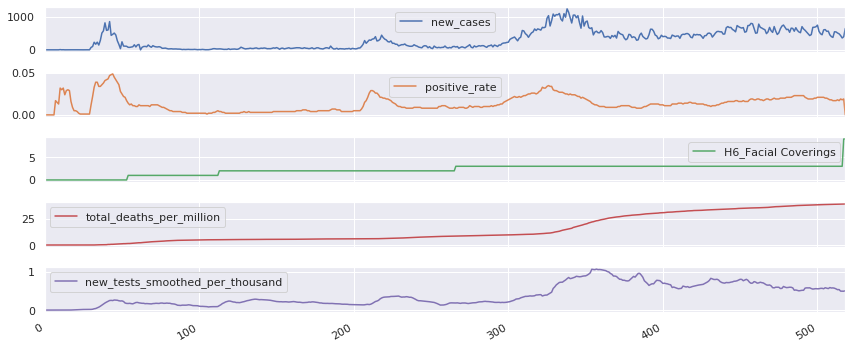

In [271]:
# 데이터 시각화
raw_kor.plot(subplots=True, figsize=(12,5))
plt.tight_layout()
plt.show()

In [272]:
adfuller_test = adfuller(raw_kor['new_cases'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -2.05846632381244
p-value: 0.26153994451493845


In [273]:
adfuller_test = adfuller(raw_kor['positive_rate'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -2.6312101231937417
p-value: 0.08671679054104586


In [274]:
adfuller_test = adfuller(raw_kor['total_deaths_per_million'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: 0.2442840496620287
p-value: 0.9746388014922968


In [275]:
adfuller_test = adfuller(raw_kor['new_tests_smoothed_per_thousand'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -1.9609648835810234
p-value: 0.30394641529134814


In [276]:
adfuller_test = adfuller(raw_kor['H6_Facial Coverings'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: 0.21874166373660273
p-value: 0.973293382548059


In [277]:
raw_kor_diff = raw_kor.diff().dropna()


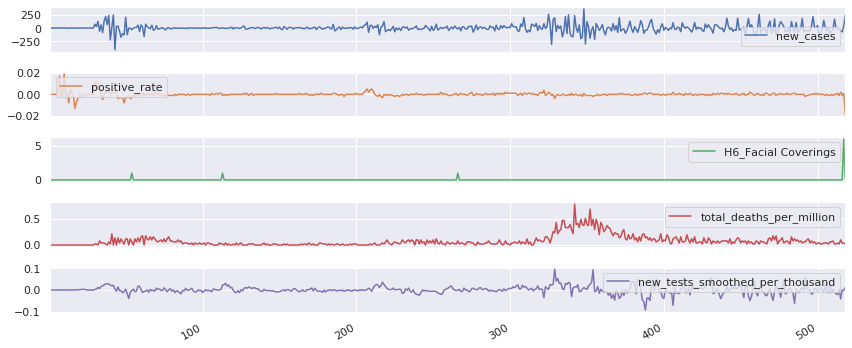

In [278]:
raw_kor_diff.plot(subplots=True, figsize=(12,5))
plt.tight_layout()
plt.show()

In [279]:
adfuller_test = adfuller(raw_kor_diff['new_cases'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -6.125091067226004
p-value: 8.667697652948969e-08


In [280]:
adfuller_test = adfuller(raw_kor_diff['positive_rate'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -5.958629330944383
p-value: 2.0643543721272862e-07


In [281]:
adfuller_test = adfuller(raw_kor_diff['total_deaths_per_million'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -3.1995496611556873
p-value: 0.020010761402041048


In [282]:
adfuller_test = adfuller(raw_kor_diff['new_tests_smoothed_per_thousand'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -3.876965514909859
p-value: 0.002211062251434725


In [283]:
adfuller_test = adfuller(raw_kor_diff['H6_Facial Coverings'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -22.78533061940134
p-value: 0.0


In [284]:
train = raw_kor_diff.iloc[:-10,:]
test = raw_kor_diff.iloc[-10:,:]

In [285]:
forecasting_model = VAR(train)
results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


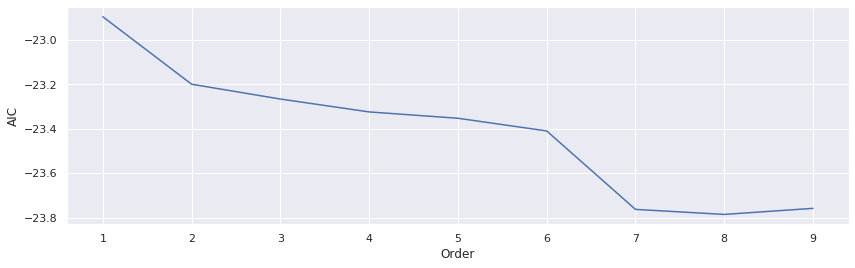

In [286]:
sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [287]:
results = forecasting_model.fit(8)
# results.summary()

In [288]:
laaged_values = train.values[-8:]

In [289]:
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=10), index = test.index, columns= ['new_cases_diff','positive_rate_diff','H6_Facial Coverings_diff','total_deaths_per_million_diff','new_tests_smoothed_per_thousand_diff'])
forecast

,new_cases_diff,positive_rate_diff,H6_Facial Coverings_diff,total_deaths_per_million_diff,new_tests_smoothed_per_thousand_diff
509,-46.207028,-0.000601,0.031309,0.027031,0.005613
510,52.297160,-0.000351,-0.004117,0.045284,0.003802
511,22.718216,-0.000829,0.003218,0.039676,0.008062
512,26.051883,-0.000131,0.015161,0.026682,-0.011529
513,-13.705074,-0.000232,0.018060,0.044288,0.000608
514,-36.740395,-0.000584,0.029810,0.032106,0.002906
515,-25.258392,0.000159,0.025566,0.040254,-0.010322
516,-6.746232,0.000128,0.009061,0.045943,-0.003077
517,13.012357,-0.000102,0.007326,0.034477,-0.001304
518,32.932449,0.000174,0.003504,0.039228,-0.005531


In [290]:
forecast["new_cases_forecasted"] = raw_kor["new_cases"].iloc[-10-1] + forecast['new_cases_diff'].cumsum()
forecast["positive_rate_forecasted"] = raw_kor["positive_rate"].iloc[-10-1] + forecast['positive_rate_diff'].cumsum()
forecast["total_deaths_per_million_forecasted"] = raw_kor["total_deaths_per_million"].iloc[-10-1] + forecast['total_deaths_per_million_diff'].cumsum()
forecast["new_tests_smoothed_per_thousand_forecasted"] = raw_kor["new_tests_smoothed_per_thousand"].iloc[-10-1] + forecast['new_tests_smoothed_per_thousand_diff'].cumsum()

forecast["H6_Facial Coverings_forecasted"] = raw_kor["H6_Facial Coverings"].iloc[-10-1] + forecast['H6_Facial Coverings_diff'].cumsum()
forecast

,new_cases_diff,positive_rate_diff,H6_Facial Coverings_diff,total_deaths_per_million_diff,new_tests_smoothed_per_thousand_diff,new_cases_forecasted,positive_rate_forecasted,total_deaths_per_million_forecasted,new_tests_smoothed_per_thousand_forecasted,H6_Facial Coverings_forecasted
509,-46.207028,-0.000601,0.031309,0.027031,0.005613,405.792972,0.017399,38.744031,0.589613,3.031309
510,52.297160,-0.000351,-0.004117,0.045284,0.003802,458.090132,0.017048,38.789316,0.593414,3.027192
511,22.718216,-0.000829,0.003218,0.039676,0.008062,480.808349,0.016219,38.828992,0.601476,3.030410
512,26.051883,-0.000131,0.015161,0.026682,-0.011529,506.860232,0.016088,38.855674,0.589947,3.045571
513,-13.705074,-0.000232,0.018060,0.044288,0.000608,493.155158,0.015856,38.899962,0.590555,3.063631
514,-36.740395,-0.000584,0.029810,0.032106,0.002906,456.414763,0.015272,38.932068,0.593461,3.093440
515,-25.258392,0.000159,0.025566,0.040254,-0.010322,431.156371,0.015431,38.972322,0.583139,3.119006
516,-6.746232,0.000128,0.009061,0.045943,-0.003077,424.410139,0.015559,39.018265,0.580062,3.128068
517,13.012357,-0.000102,0.007326,0.034477,-0.001304,437.422496,0.015457,39.052742,0.578758,3.135393
518,32.932449,0.000174,0.003504,0.039228,-0.005531,470.354945,0.015631,39.091970,0.573227,3.138897


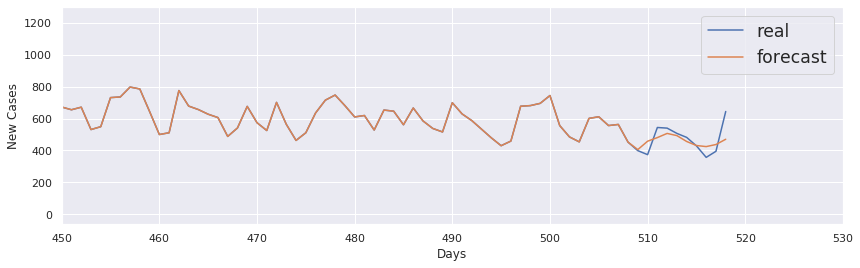

In [291]:
# train = raw_kor.iloc[:-10,:]
real4 = np.concatenate((raw_kor.iloc[:-10,:]['new_cases'], raw_kor.iloc[-10:,:]['new_cases']))
forecast4 = np.concatenate((raw_kor.iloc[:-10,:]['new_cases'], forecast["new_cases_forecasted"]))

plt.rcParams["figure.figsize"] = (14,4)
plt.plot(real4, label = "real")
plt.plot(forecast4, label = "forecast")
plt.xlim([450,530])
plt.xlabel("Days")
plt.ylabel("New Cases")
plt.legend(fontsize='x-large')
plt.show()

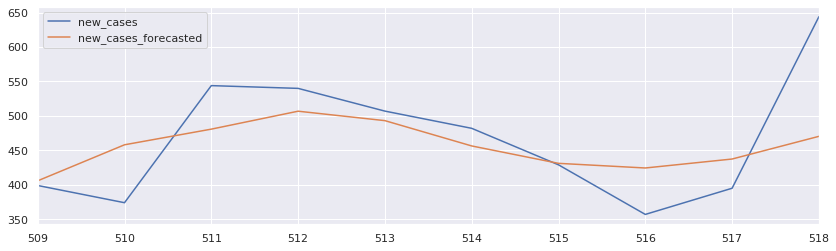

In [292]:
test = raw_kor.iloc[-10:,:1]
test["new_cases_forecasted"] = forecast["new_cases_forecasted"]

test.plot()

In [293]:
rmse = np.sqrt(mean_squared_error(test['new_cases'], test['new_cases_forecasted']))
rmse

70.39606376575314

## Long Term


In [294]:
df_temp_kor = data_kor.iloc[:, 2:]
df_out_kor = []
for col in df_temp_kor.columns.tolist():
    if(type(df_temp_kor[col]) != "str"):
        tau, p_value = stats.kendalltau(data_kor['new_cases'], df_temp_kor[col])
        df_out_kor.append([np.abs(tau), p_value, col])

In [295]:
def Sort(sub_li):
    return(sorted(sub_li, key = lambda x: x[0])) 

In [296]:
sorted_out = Sort(df_out_kor)
sorted_out[-20:]

[[0.42020298821268925, 7.6378248881956e-35, 'new_vaccinations'],
 [0.4279399728634909, 1.20293227795676e-32, 'H7_Flag'],
 [0.44381297922859475, 2.4830791023844504e-36, 'H7_Vaccination policy'],
 [0.4620078268433285, 7.381113403853731e-50, 'new_deaths'],
 [0.4620078268433285, 7.381113403853731e-50, 'new_deaths_per_million'],
 [0.4922627854362075, 1.7766127648159855e-61, 'new_deaths_smoothed'],
 [0.4922627854362075,
  1.7766127648159855e-61,
  'new_deaths_smoothed_per_million'],
 [0.5045595357926425, 5.8218431507331794e-65, 'new_tests'],
 [0.5060498864810563, 3.2290338468323855e-65, 'new_tests_per_thousand'],
 [0.5151951054419672, 2.4298682656846477e-68, 'total_tests'],
 [0.5162252894576506, 1.4960694308763062e-68, 'total_tests_per_thousand'],
 [0.5598027959084709, 9.60937687528267e-81, 'tests_per_case'],
 [0.5891215686909282, 6.937819595351103e-89, 'total_deaths'],
 [0.5891215686909282, 6.937819595351103e-89, 'total_deaths_per_million'],
 [0.5967941502458294, 1.518161244856274e-91, 'new

In [297]:
raw_kor = data_kor[['new_cases','positive_rate','H6_Facial Coverings','total_deaths_per_million','new_tests_smoothed_per_thousand']]
raw_kor

,new_cases,positive_rate,H6_Facial Coverings,total_deaths_per_million,new_tests_smoothed_per_thousand
0,0.0,0.000,0.0,0.000,0.000
1,0.0,0.000,0.0,0.000,0.000
2,0.0,0.000,0.0,0.000,0.000
3,1.0,0.000,0.0,0.000,0.000
4,0.0,0.000,0.0,0.000,0.000
...,...,...,...,...,...
514,482.0,0.017,3.0,38.951,0.532
515,429.0,0.019,3.0,39.049,0.491
516,357.0,0.018,3.0,39.088,0.491
517,395.0,0.019,9.0,39.127,0.489


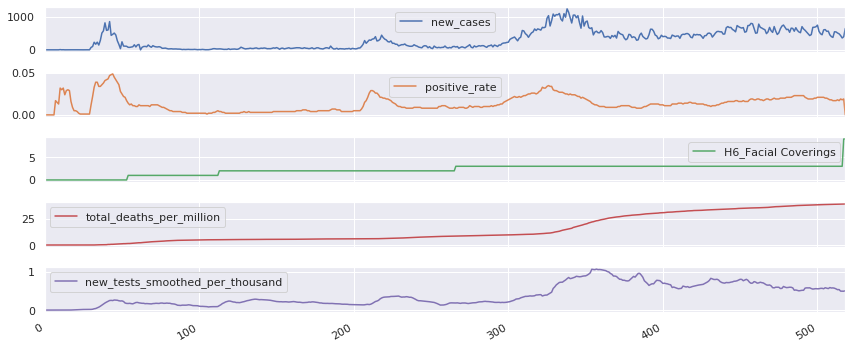

In [298]:
# 데이터 시각화
raw_kor.plot(subplots=True, figsize=(12,5))
plt.tight_layout()
plt.show()

In [299]:
adfuller_test = adfuller(raw_kor['new_cases'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -2.05846632381244
p-value: 0.26153994451493845


In [300]:
adfuller_test = adfuller(raw_kor['positive_rate'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -2.6312101231937417
p-value: 0.08671679054104586


In [301]:
adfuller_test = adfuller(raw_kor['total_deaths_per_million'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: 0.2442840496620287
p-value: 0.9746388014922968


In [302]:
adfuller_test = adfuller(raw_kor['new_tests_smoothed_per_thousand'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -1.9609648835810234
p-value: 0.30394641529134814


In [303]:
adfuller_test = adfuller(raw_kor['H6_Facial Coverings'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: 0.21874166373660273
p-value: 0.973293382548059


In [304]:
raw_kor_diff = raw_kor.diff().dropna()


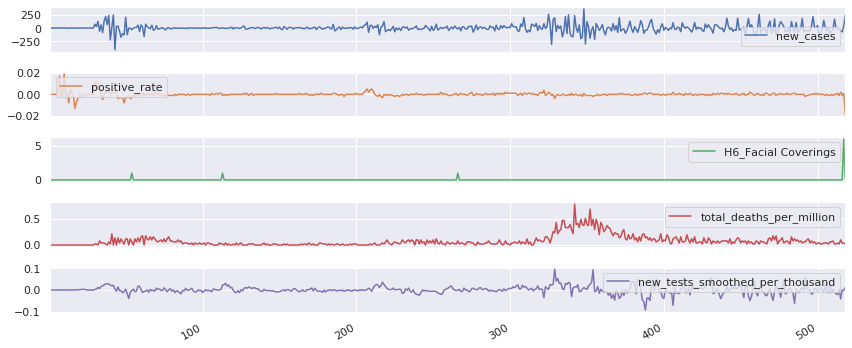

In [305]:
raw_kor_diff.plot(subplots=True, figsize=(12,5))
plt.tight_layout()
plt.show()

In [306]:
adfuller_test = adfuller(raw_kor_diff['new_cases'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -6.125091067226004
p-value: 8.667697652948969e-08


In [307]:
adfuller_test = adfuller(raw_kor_diff['positive_rate'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -5.958629330944383
p-value: 2.0643543721272862e-07


In [308]:
adfuller_test = adfuller(raw_kor_diff['total_deaths_per_million'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -3.1995496611556873
p-value: 0.020010761402041048


In [309]:
adfuller_test = adfuller(raw_kor_diff['new_tests_smoothed_per_thousand'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -3.876965514909859
p-value: 0.002211062251434725


In [310]:
adfuller_test = adfuller(raw_kor_diff['H6_Facial Coverings'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -22.78533061940134
p-value: 0.0


In [311]:
train = raw_kor_diff.iloc[:-30,:]
test = raw_kor_diff.iloc[-30:,:]

In [312]:
forecasting_model = VAR(train)
results_aic = []
for p in range(1,30):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


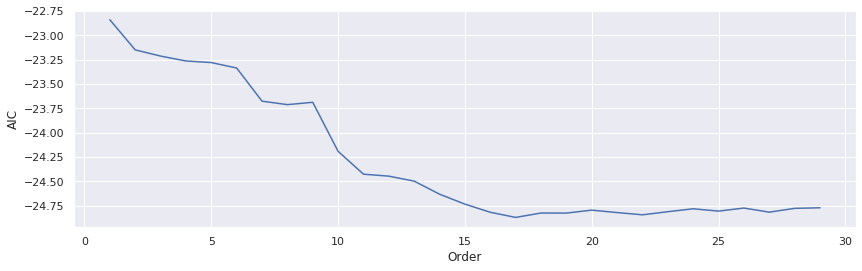

In [313]:
sns.set()
plt.plot(list(np.arange(1,30,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [314]:
results = forecasting_model.fit(18)
# results.summary()

In [315]:
laaged_values = train.values[-18:]

In [316]:
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=30), index = test.index, columns= ['new_cases_diff','positive_rate_diff','H6_Facial Coverings_diff','total_deaths_per_million_diff','new_tests_smoothed_per_thousand_diff'])
forecast

,new_cases_diff,positive_rate_diff,H6_Facial Coverings_diff,total_deaths_per_million_diff,new_tests_smoothed_per_thousand_diff
489,30.323787,0.000510,-0.003378,0.033974,-0.011550
490,35.531756,-0.000141,0.047510,0.069379,-0.004067
491,94.905701,0.000087,0.023256,0.078379,-0.010665
492,30.653005,-0.000039,0.011944,0.104064,0.020728
493,-31.937345,-0.000352,0.045300,0.074188,0.012909
494,-85.021532,0.000318,0.005597,0.054578,0.002888
495,14.066206,0.000101,0.014711,0.083198,0.005178
496,-35.171271,-0.000061,0.019240,0.068174,0.012117
497,29.942733,-0.000212,-0.031614,0.140245,0.005075
498,53.572470,-0.000237,0.033194,0.026760,0.009352


In [317]:
forecast["new_cases_forecasted"] = raw_kor["new_cases"].iloc[-30-1] + forecast['new_cases_diff'].cumsum()
forecast["positive_rate_forecasted"] = raw_kor["positive_rate"].iloc[-30-1] + forecast['positive_rate_diff'].cumsum()
forecast["total_deaths_per_million_forecasted"] = raw_kor["total_deaths_per_million"].iloc[-30-1] + forecast['total_deaths_per_million_diff'].cumsum()
forecast["new_tests_smoothed_per_thousand_forecasted"] = raw_kor["new_tests_smoothed_per_thousand"].iloc[-30-1] + forecast['new_tests_smoothed_per_thousand_diff'].cumsum()

forecast["H6_Facial Coverings_forecasted"] = raw_kor["H6_Facial Coverings"].iloc[-30-1] + forecast['H6_Facial Coverings_diff'].cumsum()
forecast

,new_cases_diff,positive_rate_diff,H6_Facial Coverings_diff,total_deaths_per_million_diff,new_tests_smoothed_per_thousand_diff,new_cases_forecasted,positive_rate_forecasted,total_deaths_per_million_forecasted,new_tests_smoothed_per_thousand_forecasted,H6_Facial Coverings_forecasted
489,30.323787,0.000510,-0.003378,0.033974,-0.011550,568.323787,0.023510,37.755974,0.487450,2.996622
490,35.531756,-0.000141,0.047510,0.069379,-0.004067,603.855544,0.023369,37.825354,0.483382,3.044132
491,94.905701,0.000087,0.023256,0.078379,-0.010665,698.761245,0.023456,37.903732,0.472717,3.067389
492,30.653005,-0.000039,0.011944,0.104064,0.020728,729.414249,0.023417,38.007797,0.493445,3.079333
493,-31.937345,-0.000352,0.045300,0.074188,0.012909,697.476904,0.023065,38.081985,0.506354,3.124633
494,-85.021532,0.000318,0.005597,0.054578,0.002888,612.455372,0.023384,38.136563,0.509241,3.130230
495,14.066206,0.000101,0.014711,0.083198,0.005178,626.521579,0.023484,38.219762,0.514419,3.144940
496,-35.171271,-0.000061,0.019240,0.068174,0.012117,591.350307,0.023424,38.287936,0.526536,3.164180
497,29.942733,-0.000212,-0.031614,0.140245,0.005075,621.293041,0.023211,38.428181,0.531611,3.132566
498,53.572470,-0.000237,0.033194,0.026760,0.009352,674.865511,0.022974,38.454942,0.540963,3.165761


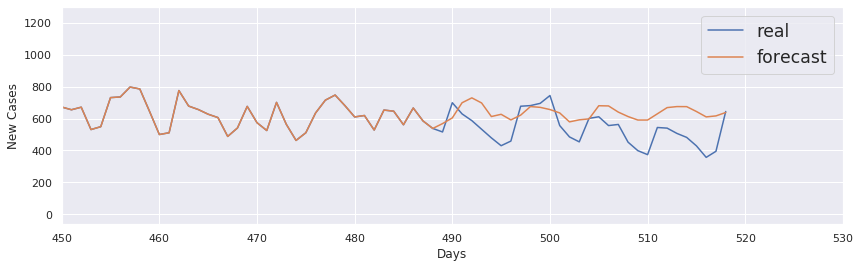

In [318]:
# train = raw_kor.iloc[:-10,:]
real4 = np.concatenate((raw_kor.iloc[:-30,:]['new_cases'], raw_kor.iloc[-30:,:]['new_cases']))
forecast4 = np.concatenate((raw_kor.iloc[:-30,:]['new_cases'], forecast["new_cases_forecasted"]))

plt.rcParams["figure.figsize"] = (14,4)
plt.plot(real4, label = "real")
plt.plot(forecast4, label = "forecast")
plt.xlim([450,530])
plt.xlabel("Days")
plt.ylabel("New Cases")
plt.legend(fontsize='x-large')
plt.show()

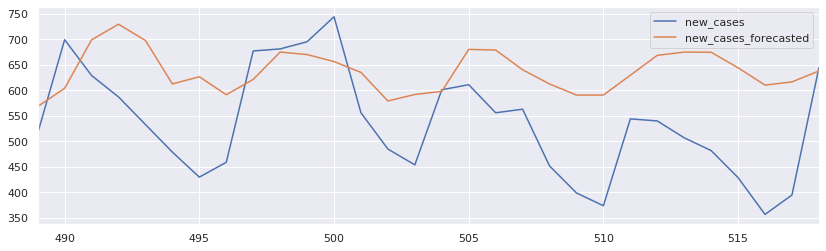

In [319]:
test = raw_kor.iloc[-30:,:1]
test["new_cases_forecasted"] = forecast["new_cases_forecasted"]

test.plot()

In [320]:
rmse = np.sqrt(mean_squared_error(test['new_cases'], test['new_cases_forecasted']))
rmse

137.50257395970198